In [148]:
import glob
import os
import re

import numpy as np
from skimage import io
from keras.utils.np_utils import to_categorical  


from sklearn.preprocessing import OneHotEncoder

def read_cifar10():
    cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    file_spec = '*.png'
    train_path = os.path.join('CIFAR10/Train/*/', file_spec)
    test_path = os.path.join('CIFAR10/Test/*/', file_spec)

    train_collection= io.imread_collection(train_path)
    test_collection = io.imread_collection(test_path)
    # Normalization of pixel values (to [0-1] range)
    train_images = np.stack(train_collection).astype(float) / 255
    test_images = np.stack(test_collection).astype(float) / 255
    
    
    #Use sklearn package for one-hot-encoder
    label_encoder = OneHotEncoder()
    train_label =[]
    test_label =[]
    for file in train_collection.files:
        train_label.append(int(re.split("/",file)[2]))
    train_set=pd.DataFrame(train_label)
    train_labels=label_encoder.fit_transform(train_set[[0]]).toarray()
    #label_encoder.fit
    for file in test_collection.files:
        test_label.append(int(re.split("/",file)[2]))
    test_set=pd.DataFrame(test_label)
    test_labels=label_encoder.fit_transform(test_set[[0]]).toarray()
    return train_images, train_labels, test_images, test_labels

X_train, y_train, X_test, y_test = read_cifar10()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10000, 28, 28), (10000, 10), (1000, 28, 28), (1000, 10))

/Users/cz/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.08
step 0, training loss 5.21778
step 1000, training accuracy 0.16
step 1000, training loss 2.91727
step 2000, training accuracy 0.28
step 2000, training loss 2.27441
step 3000, training accuracy 0.38
step 3000, training loss 1.93839
step 4000, training accuracy 0.32
step 4000, training loss 2.25674
test accuracy 0.393


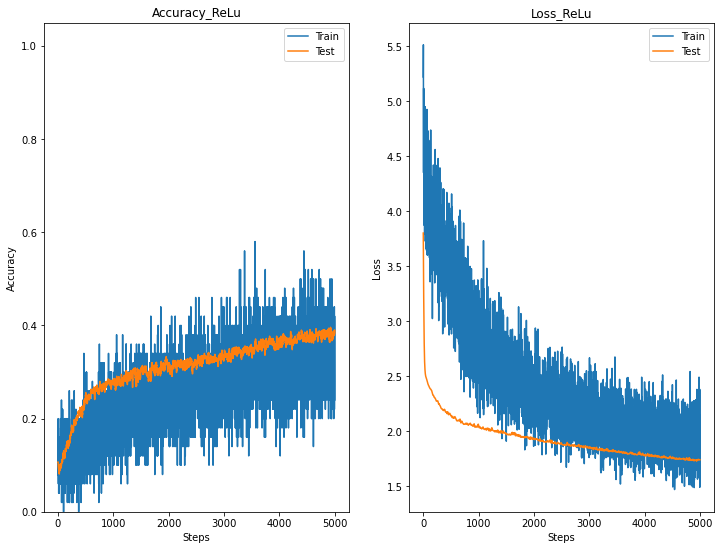

In [186]:
from scipy import misc
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
import matplotlib.pyplot as plt
import matplotlib as mp
import imageio


# --------------------------------------------------
# setup

def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''

    # IMPLEMENT YOUR WEIGHT_VARIABLE HERE
    W = tf.truncated_normal(shape, stddev=0.1)
    #initial = tf.compat.v1.keras.initializers.glorot_normal()
    #W = initial (shape)
    return tf.Variable(W)

def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''

    # IMPLEMENT YOUR BIAS_VARIABLE HERE
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters = the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the filters, a.k.a. the results after convolution
    '''

    # IMPLEMENT YOUR CONV2D HERE
    h_conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    return h_conv

def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''

    # IMPLEMENT YOUR MAX_POOL_2X2 HERE
    h_max = tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')
    return h_max

def main():
    ntrain = 800 # per class
    ntest = 100 # per class
    nclass =10  # number of classes
    imsize = 28
    nchannels = 1
    batchsize = 50

    Train = np.zeros((ntrain*nclass,imsize,imsize,nchannels))
    Test = np.zeros((ntest*nclass,imsize,imsize,nchannels))
    LTrain = np.zeros((ntrain*nclass,nclass))
    LTest = np.zeros((ntest*nclass,nclass))

    itrain = -1
    itest = -1
    for iclass in range(0, nclass):
        for isample in range(0, ntrain):
            path = 'CIFAR10/Train/%d/Image%05d.png' % (iclass,isample)
            im = imageio.imread(path); # 28 by 28
            im = im.astype(float)/255
            itrain += 1
            Train[itrain,:,:,0] = im
            LTrain[itrain,iclass] = 1 # 1-hot lable
        for isample in range(0, ntest):
            path = 'CIFAR10/Test/%d/Image%05d.png' % (iclass,isample)
            im = imageio.imread(path); # 28 by 28
            im = im.astype(float)/255
            itest += 1
            Test[itest,:,:,0] = im
            LTest[itest,iclass] = 1 # 1-hot lable

    sess = tf.InteractiveSession()


    #tf variable for the data, remember shape is [None, width, height, numberOfChannels]
    tf_data = tf.placeholder(tf.float32, [None, imsize,imsize,nchannels]) 
    #tf variable for labels
    tf_labels = tf.placeholder(tf.float32, [None, nclass])

    # --------------------------------------------------
    # model
    #create your model
    # Convolutional layer with kernel 5 x 5 and 32 filter maps followed by ReLU
    #Max Pooling layer subsampling by 2
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(tf_data, W_conv1) + b_conv1) #
    h_pool1 = max_pool_2x2(h_conv1)

    # second convolutional layer
    #Convolutional layer with kernel 5 x 5 and 64 filter maps followed by ReLU
    #Max Pooling layer subsampling by 2
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])             
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)#
    h_pool2 = max_pool_2x2(h_conv2)

    #Fully Connected layer that has input 7*7*64 and output 1024
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    h_fc1 = tf.nn.tanh(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)#

    # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)                           

    #Fully Connected layer that has input 1024 and output 10 (for the classes)
    #Softmax layer (Softmax Regression + Softmax Nonlinearity)                           

    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    # --------------------------------------------------
    # loss
    #set up the loss, optimization, evaluation, and accuracy
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_labels, logits=y_conv))

    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(tf_labels, 1))

    # --------------------------------------------------
    # optimization
    #optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    optimizer = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy)
    #optimizer = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    #optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(cross_entropy)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')      

    sess.run(tf.initialize_all_variables())
                           
    #setup as [batchsize, width, height, numberOfChannels] and use np.zeros()
    batch_xs = np.zeros((batchsize, imsize, imsize, nchannels))
    #setup as [batchsize, the how many classes]
    batch_ys = np.zeros((batchsize, nclass))
    #step_size = 8000
    step_size = 5000
 
    train_accuracy_list = []
    train_loss_list = []
    step_list = []
    test_accuracy_list = []
    test_loss_list = []
    for i in range(step_size): # try a small iteration size once it works then continue
        perm = np.arange(ntrain*nclass)
        np.random.shuffle(perm)
        for j in range(batchsize):
            batch_xs[j,:,:,:] = Train[perm[j],:,:,:]
            batch_ys[j,:] = LTrain[perm[j],:]
        train_accuracy = accuracy.eval(feed_dict={
            tf_data: batch_xs, tf_labels: batch_ys, keep_prob: 0.5})
        train_accuracy_list.append(train_accuracy)
        train_loss = cross_entropy.eval(feed_dict={
            tf_data: batch_xs, tf_labels: batch_ys, keep_prob: 0.5})
        train_loss_list.append(train_loss)
        step_list.append(i)
                
        test_accuracy = accuracy.eval(feed_dict={tf_data: Test, tf_labels: LTest, keep_prob: 1.0})
        test_accuracy_list.append(test_accuracy)
        test_loss = cross_entropy.eval(feed_dict={tf_data: Test, tf_labels: LTest, keep_prob: 1.0})
        test_loss_list.append(test_loss)    
            
        if i%1000 == 0 or i == step_size:
            #calculate train accuracy and print it
            print("step %d, training accuracy %g" % (i, train_accuracy))
            print("step %d, training loss %g" % (i, train_loss))
    
        optimizer.run(feed_dict={tf_data: batch_xs, tf_labels: batch_ys, keep_prob: 0.5}) # dropout only during training

    # --------------------------------------------------
    # test
    print("test accuracy %g" % accuracy.eval(feed_dict={tf_data: Test, tf_labels: LTest, keep_prob: 1.0}))
    
    plt.figure(figsize=(12, 9))
    plt.subplot(1, 2, 1)
    plt.plot(np.array(step_list), train_accuracy_list, label='Train')
    plt.plot(np.array(step_list), test_accuracy_list, label='Test')
    plt.title('Accuracy_ReLu')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    
    plt.subplot(1, 2, 2)
    plt.plot(np.array(step_list), train_loss_list, label='Train')
    plt.plot(np.array(step_list), test_loss_list, label='Test')
    plt.title('Loss_ReLu')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()
    
    # calculate statistics of the activations
    h1 = h_conv1.eval(feed_dict = {tf_data: Test, tf_labels: LTest, keep_prob: 1.0})
    h2 = h_conv2.eval(feed_dict = {tf_data: Test, tf_labels: LTest, keep_prob: 1.0})
    mean_h1 = np.mean(np.array(h1))
    std_h1 = np.std(np.array(h1))
    var_h1 = np.var(np.array(h1))
    mean_h2 = np.mean(np.array(h2))
    std_h2 = np.std(np.array(h2))
    var_h2 = np.var(np.array(h2))
    print("ReLu activation 1: mean %g, standard deviation %g, variance %g" % (mean_h1, std_h1, var_h1))
    print("ReLu activation 2: mean %g, standard deviation %g, variance %g" % (mean_h2, std_h2, var_h2))
    
    n_filters, ix = 32, 1      
    for i in range(n_filters):
        f = first_conv_weight[:, :, :, i]
        # specify subplot and turn of axis
        ax = plt.subplot(4, 8, ix)
        # plot filter channel in grayscale
        plt.imshow(f[:, :, 0], cmap='gray')
        ix += 1
        plt.axis('off')
    # show the figure
    plt.show()
    sess.close()
                           
if __name__ == "__main__":
    main()
